## Brain Tumor Detection (MRI)

In [1]:
import numpy as np 
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
# DataLoader used for crating minibatches (for faster iterations)
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import sys
import cv2

## Reading the images 

In [2]:
tumor = []
path = './brain_tumor_dataset/yes/*.jpg'
#iterating through the images
for i in glob.iglob(path):
    img = cv2.imread(i)
    img= cv2.resize(img, (128,128)) #creating homogenous image dataset
    r,g,b = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

In [3]:
healthy = []
path = './brain_tumor_dataset/no/*.jpg'
#iterating through the images
for i in glob.iglob(path):
    img = cv2.imread(i)
    img= cv2.resize(img, (128,128)) #creating homogenous image dataset
    r,g,b = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [4]:
tumor= np.array(tumor)
healthy = np.array(healthy)

In [5]:
# Checking the shape 
tumor.shape

(154, 128, 128, 3)

In [6]:
healthy.shape

(91, 128, 128, 3)

### Visualizing Brain MRI images

In [7]:
def plot_rand (healthy, tumor, num=5):
    healthy_img= healthy[np.random.choice(healthy.shape[0], num, replace= False)]
    tumor_img= tumor[np.random.choice(tumor.shape[0], num, replace= False)]
    
    plt.figure(figsize=(16,9))
    for f in range(num):
        plt.subplot(1, num, f+1)
        plt.title('Healthy_Brain')
        plt.imshow(healthy_img[f])

    
    plt.figure(figsize=(16,9))
    for f in range(num):
        plt.subplot(1, num, f+1)
        plt.title('Tumor_Brain')
        plt.imshow(tumor_img[f])

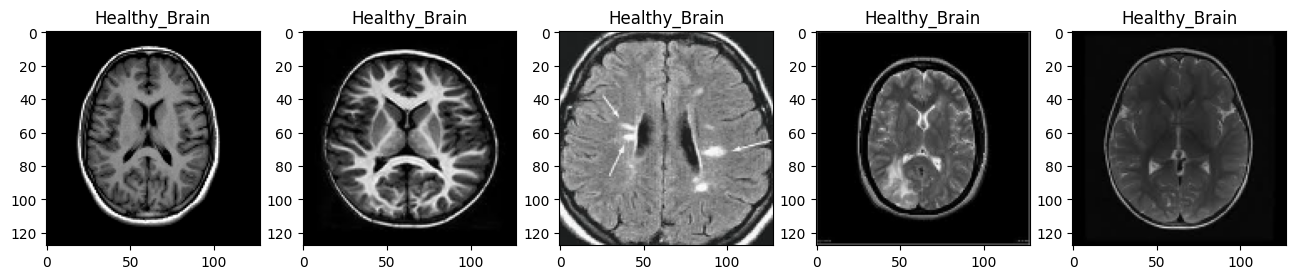

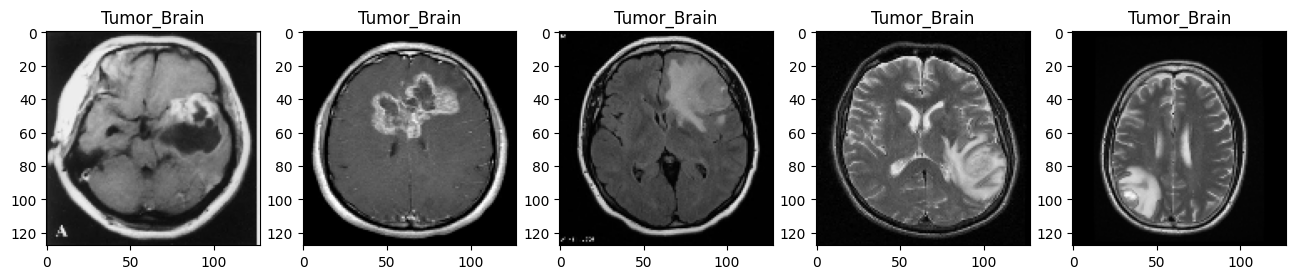

In [8]:
plot_rand(healthy, tumor)

### Creating torch dataset class

In [9]:
## Parent Class
class Dataset(object):

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

### Creating custom MRI class 

In [10]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        healthy = []
        path = './brain_tumor_dataset/yes/*.jpg'
        #iterating through the images
        for i in glob.iglob(path):
            img = cv2.imread(i)
            img= cv2.resize(img, (128,128)) #creating homogenous image dataset
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            tumor.append(img)
        path = './brain_tumor_dataset/no/*.jpg'
        #iterating through the images
        for i in glob.iglob(path):
            img = cv2.imread(i)
            img= cv2.resize(img, (128,128)) #creating homogenous image dataset
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            healthy.append(img)
        #our images
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype= np.float32)

        #our labels
        tumor_label = np.ones(tumor.shape[0], dtype= np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype= np.float32)

        #concatenate
        self.images=np.concatenate((tumor, healthy),axis =0) 
        # axis =0 meaning --> d1= [2,4,1,3] d2=[5,4,1,3] :: d = d1 concat d2 --> [7,4,1,3] {just add the first axis value :) }
        self.labels= np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        sample= {'image':self.images[index], 'label':self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images/255.0

In [11]:
mri= MRI()
mri.normalize()

## Create a dataloader

In [12]:
names= {0:'Healthy_Brain', 1:'Tumor_Brain'}
dataloader = DataLoader(mri, shuffle= True)

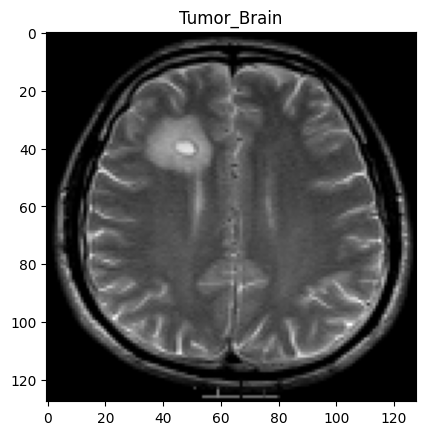

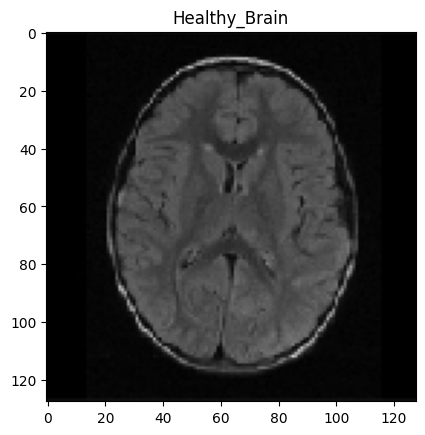

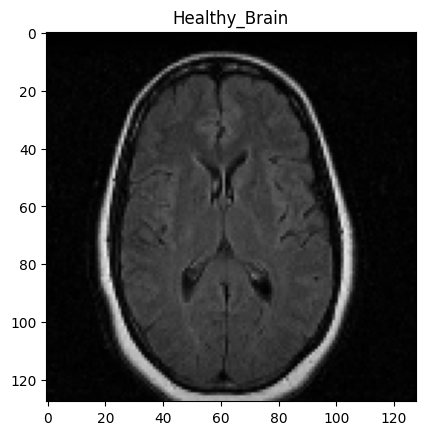

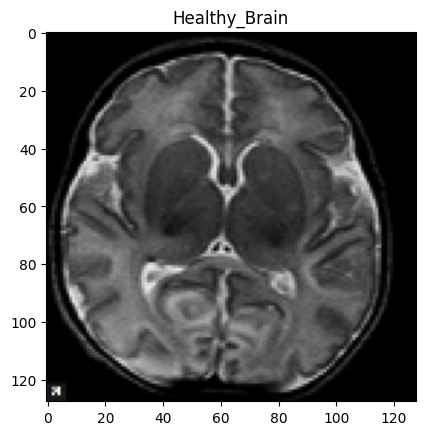

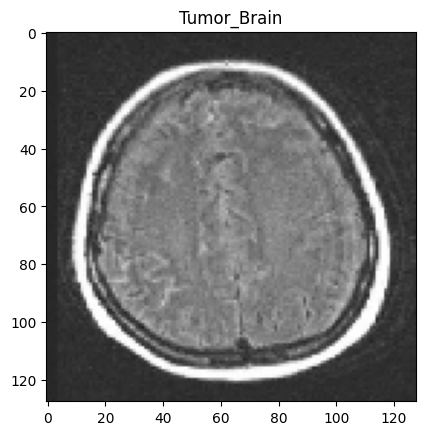

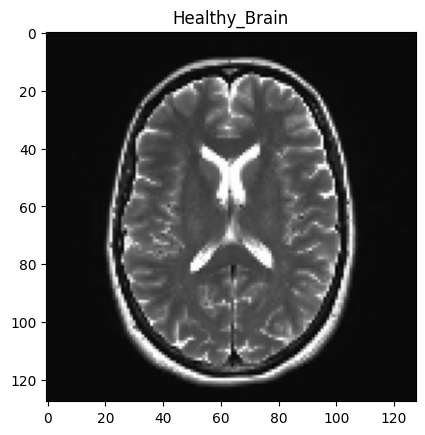

In [13]:
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

## Creating a CNN model

<center><img src="./notebook_imgs/CNN_model.png" /></center>

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5), 
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride= 5), 
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), #output of prev conv_layer is now the input of this layer 
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride= 5)
        )
        
        #fully connected layers
        self.fc_model = nn.Sequential( 
            nn.Linear(in_features = 256, out_features= 120), #Logic explained in block below
            nn.Tanh(), 
            nn.Linear(in_features = 120, out_features= 84), 
            nn.Tanh(),
            nn.Linear(in_features = 84, out_features= 1)
        )

    def forward(self, x):
        x= self.cnn_model(x)
        x= x.view(x.size(0), -1) #flattening the 2D array:: to understand this go through block below 
        x= self.fc_model(x)
        x= F.sigmoid(x)


        return x

### Logic behind the numbers:

$$n_{out}= ceil[\frac{n_{in}+2p -f}s +1]$$

#### In the initial state:
<center><img src="./notebook_imgs/just a slight note.gif" /></center>

and on further going through, we get to the point where we encounter $$4×4×16 = 256$$ layers till we reach model.Sequential 

### Looking into the parameters in the model

In [15]:
model = CNN()

In [16]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

#### Getting inside the linear layer

In [17]:
model.fc_model

Sequential(
  (0): Linear(in_features=256, out_features=120, bias=True)
  (1): Tanh()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): Tanh()
  (4): Linear(in_features=84, out_features=1, bias=True)
)

In [18]:
model.fc_model[0]

Linear(in_features=256, out_features=120, bias=True)

In [19]:
model.fc_model[0].weight.shape

torch.Size([120, 256])

#### Understanding ```x.view(x.size(0),-1)```

In [20]:
# creating a tensor 
x = torch.tensor([1,2,3,4,5,6,7,8,9,11,12,10,13,14,20,21])

In [21]:
#Reshaping....
x= x.reshape((2,2,2,2))

In [22]:
x

tensor([[[[ 1,  2],
          [ 3,  4]],

         [[ 5,  6],
          [ 7,  8]]],


        [[[ 9, 11],
          [12, 10]],

         [[13, 14],
          [20, 21]]]])

In [23]:
x.size()
# and if we run x.size(0), output would just be 2

torch.Size([2, 2, 2, 2])

The last three is similar to the channels and dimension but what's up with the 1st tensor??
Well, ```x.size(0)``` gives us the number of images in that batch size while we are training 

In [24]:
x.view(-1)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 10, 13, 14, 20, 21])

So, what it did was.. It flattened the 2D tensor to the 1D tensor just by negating a dimension.
Now when we go for ```x.view(x.size(0),-1)```, it's basically ```x.view(2,-1)```. i.e., flatenning each input datas independently and passing through fc_models and sigmoids  

In [25]:
x.view(x.size(0),-1)

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 11, 12, 10, 13, 14, 20, 21]])

### Diving into basics of Training and Evaluation in Pytorch

#### 1. ```model.eval()```

* Used for disabling the dropout and has the batch_norm of entire population stats. This is necesssary for inference.
* Nothing to do with gradients

#### 2. ```model.train()```

* Brings dropout and batch_norm to action (ie. the train mode)
* Gradients are computed 

#### 3. NumPy Array vs Tensor

##### NumPy Array
- Part of NumPy library
- Supports numeric data types
- Optimized for numerical operations
- Primarily CPU-based

##### Tensor
- Part of TensorFlow/PyTorch
- Supports various data types
- Designed for deep learning
- Optimized for both CPU and GPU

#### 4. ```torch.Tensor``` vs ```torch.cuda.Tensor```

##### torch.Tensor
- Represents a tensor on the CPU.
- Supports all standard tensor operations.
- Typically slower for large-scale computations compared to GPU.<br><br>
<b>Example</b>
```python
import torch

# Create a tensor on CPU
cpu_tensor = torch.tensor([1, 2, 3])
print(cpu_tensor)

##### torch.cuda.Tensor
- Represents a tensor on the GPU.
- Accelerated computation using GPU.
- Requires CUDA-compatible device and PyTorch with CUDA support.<br><br>
<b>Example:</b>
```python
import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Create a tensor on GPU
    gpu_tensor = torch.tensor([1, 2, 3], device='cuda')
    print(gpu_tensor)
else:
    print("CUDA is not available")
```

#### 5. When is ```torch.cuda.Tensor()``` necessary?
* **Large-scale computations:** When working with large datasets or complex models, using the GPU can significantly speed up computations.
* **Deep learning models:** Training neural networks, especially deep and complex architectures, benefits from the parallel processing capabilities of the GPU.
* **Real-time applications:** Applications that require real-time or near-real-time processing, such as image and video processing, benefit from GPU acceleration.
* **Batch processing:** When performing batch operations on large data, GPUs can process multiple data points simultaneously, leading to faster performance.

#### 6. ```tensor.cpu().detach().numpy()```: Convert Pytorch tensor to Numpy array
np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must explicitly remove the computational graph of the tensor using the detach() command. .cpu() returns a copy of this object in CPU memory.

### Evaluating how smart a NN is before training it 

In [26]:
mri_dataset = MRI()
mri_dataset.normalize()

device = torch.device('cuda:0') 

model= CNN().to(device)

In [27]:
dataloader = DataLoader(mri_dataset, batch_size= 32, shuffle= False)

In [28]:
model.eval()
outputs = []
y_true =[]

with torch.no_grad():  # we dont compute gradient during eval() 
    for D in dataloader:
        image= D['image'].to(device) #since data lives in CPU, trasferring it to our GPU
        label= D['label'].to(device)
        #Since I had [batch_size, 128,128,3] format it cound not take into function so reshaping using torch permute fuction
        ''' Note: np.transform() wont work here and after using permute, call .contiguous() to ensure that the tensor is stored 
        in a contiguous chunk of memory, which allows you to safely reshape it. '''
        image= image.permute(0,3,1,2).contiguous()
        
        #print(image.shape)
        
        y_hat= model(image) #passing into forward function
        outputs.append(y_hat.cpu().detach().numpy()) #Converting to numpy array and appending...
        y_true.append(label.cpu().detach().numpy())

In [29]:
outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

In [30]:
# defining threshold for sigmoid...
def threshold(scores, threshold= 0.50, minimum =0.0, maximum=1.0):
    x= np.array(list(scores))
    x[x >= threshold]= maximum
    x[x < threshold] = minimum
    return x

In [31]:
accuracy_score(y_true, threshold(outputs))

0.6285714285714286

$$Accuracy\_score = \frac{TP + TN}{TP+TN+FP+FN}$$

where, <center><br>**TP** :: True Positive <br>
       **FP** :: False Positive <br>
       **TN** :: True Negative <br>
       **FN** :: False Negative <br></center>

### Now Training The NN and testing if the score gets higher 

In [48]:
alpha = 0.0001 #learning rate
optimizer = torch.optim.Adam(model.parameters(), lr= alpha)
EPOCH = 250
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle= True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [49]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad() #to make sure cache is removed before computing 
        data= D['image'].to(device) 
        label= D['label'].to(device)
        data= data.permute(0,3,1,2).contiguous()
        y_hat = model(data)

        #defining the loss function
        error = nn.BCELoss()

        loss =torch.sum(error(y_hat.squeeze(), label)) #forward pass complete 

        #going for back_propagation
        loss.backward()
        optimizer.step()
        losses.append(loss.item()) #keeping track of each individual error value 

    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.225210
Train Epoch: 20	Loss: 0.228789
Train Epoch: 30	Loss: 0.204303
Train Epoch: 40	Loss: 0.192787
Train Epoch: 50	Loss: 0.184402
Train Epoch: 60	Loss: 0.176846
Train Epoch: 70	Loss: 0.150011
Train Epoch: 80	Loss: 0.133108
Train Epoch: 90	Loss: 0.122187
Train Epoch: 100	Loss: 0.100866
Train Epoch: 110	Loss: 0.097111
Train Epoch: 120	Loss: 0.088221
Train Epoch: 130	Loss: 0.065077
Train Epoch: 140	Loss: 0.057563
Train Epoch: 150	Loss: 0.045501
Train Epoch: 160	Loss: 0.042427
Train Epoch: 170	Loss: 0.034384
Train Epoch: 180	Loss: 0.027700
Train Epoch: 190	Loss: 0.022726
Train Epoch: 200	Loss: 0.018401
Train Epoch: 210	Loss: 0.016228
Train Epoch: 220	Loss: 0.013442
Train Epoch: 230	Loss: 0.011446
Train Epoch: 240	Loss: 0.009759
Train Epoch: 250	Loss: 0.008100


### Evaluating the smart model

In [50]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        image= image.permute(0,3,1,2).contiguous()
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [51]:
accuracy_score(y_true, threshold(outputs))

1.0

So the accuracy is now >90%. <br>
Now, visualizing the output in confusion matrix:

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

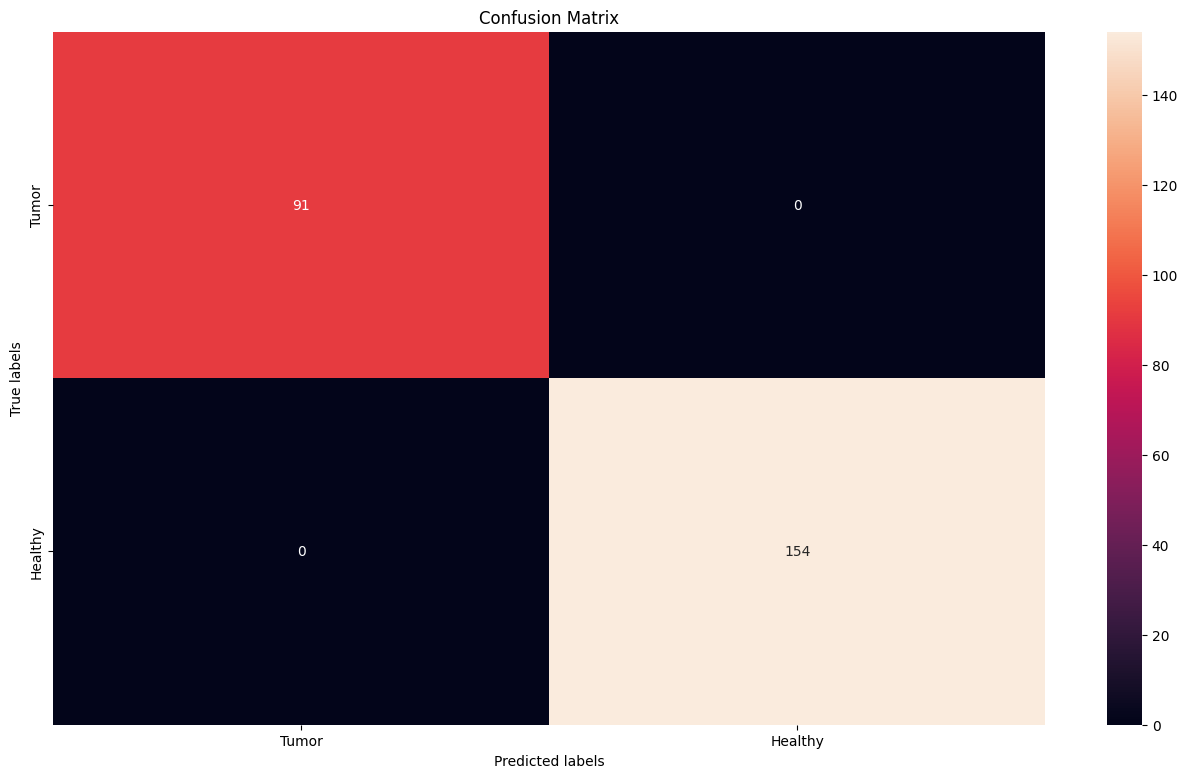

In [52]:
import seaborn as sns

cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

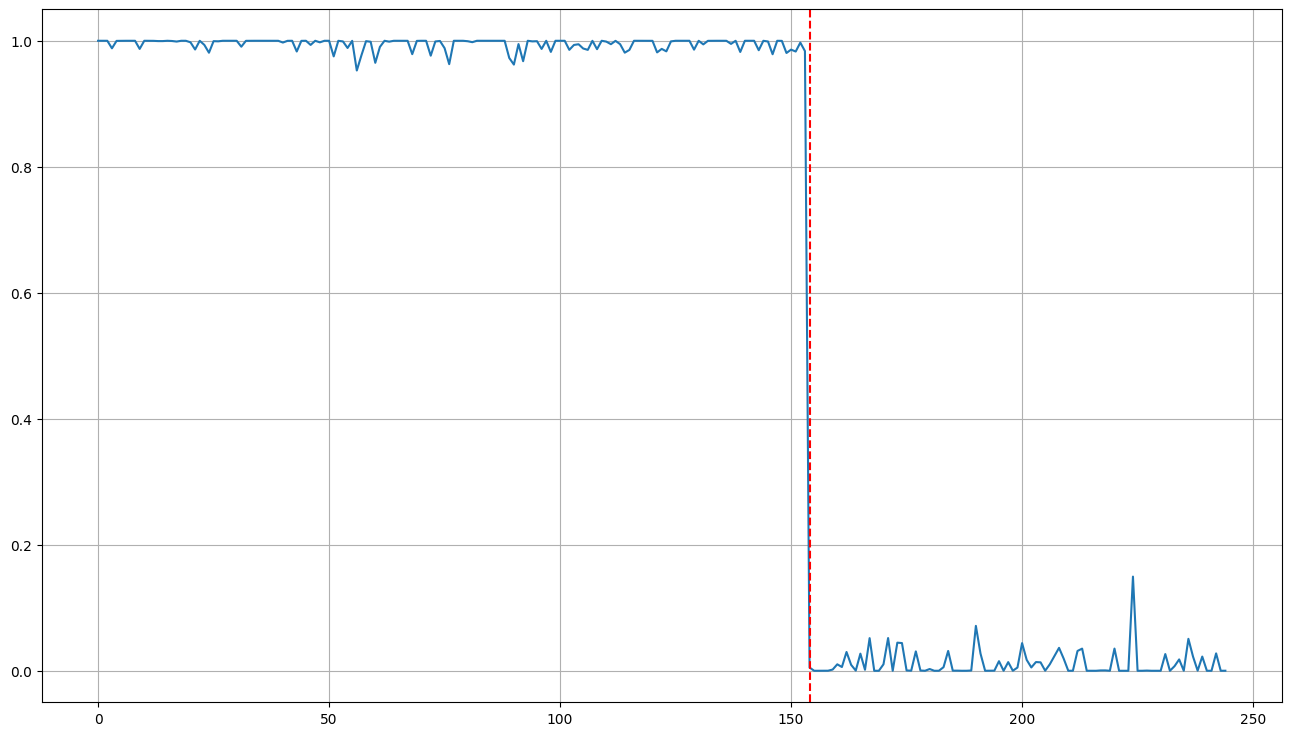

In [53]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

### Visualising Feature maps of Convolutional Filters

In [54]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [55]:
num_layers = 0
conv_layers = []

In [56]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [57]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                num_layers += 1
                conv_layers.append(layer)

In [58]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

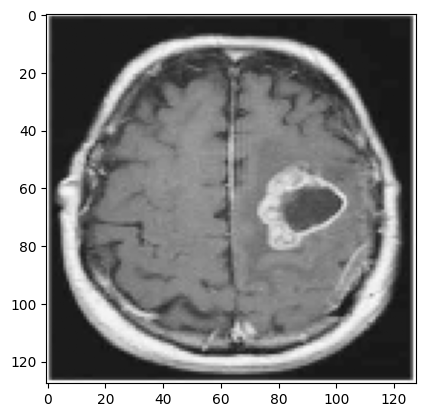

In [59]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [60]:
img = torch.from_numpy(img).to(device)
img.shape

torch.Size([128, 128, 3])

In [61]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 128, 128, 3])

In [62]:
img = img.permute(0, 3, 1, 2) 
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


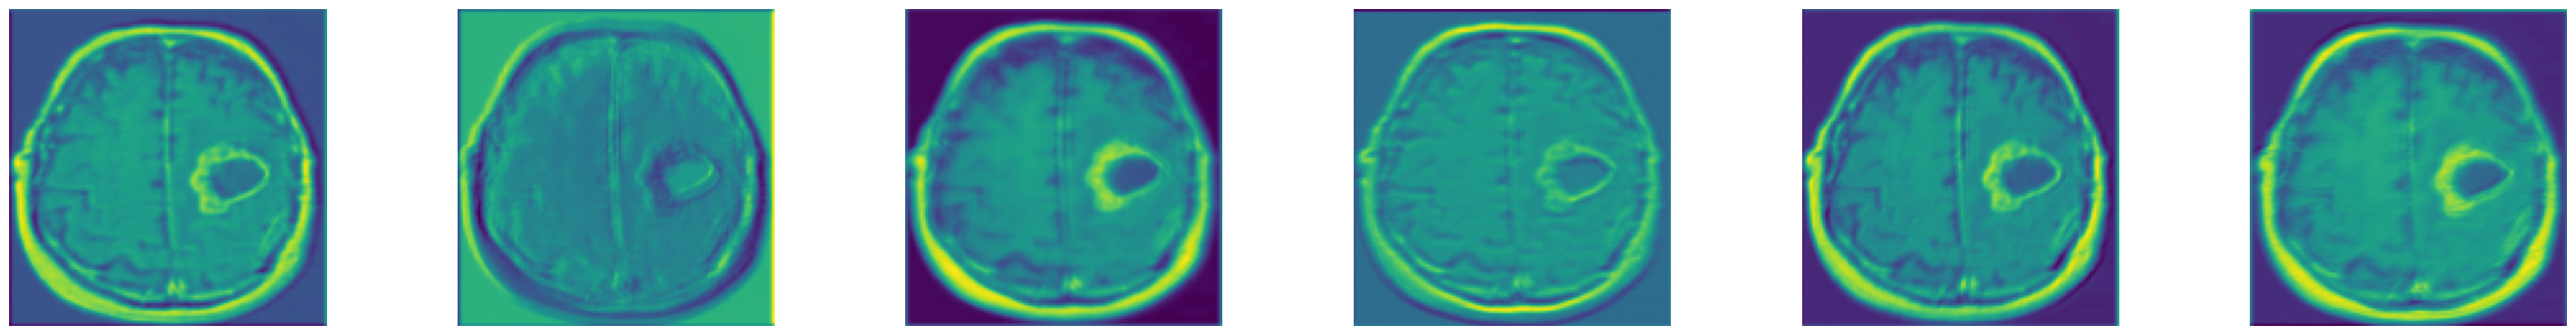

Layer  2


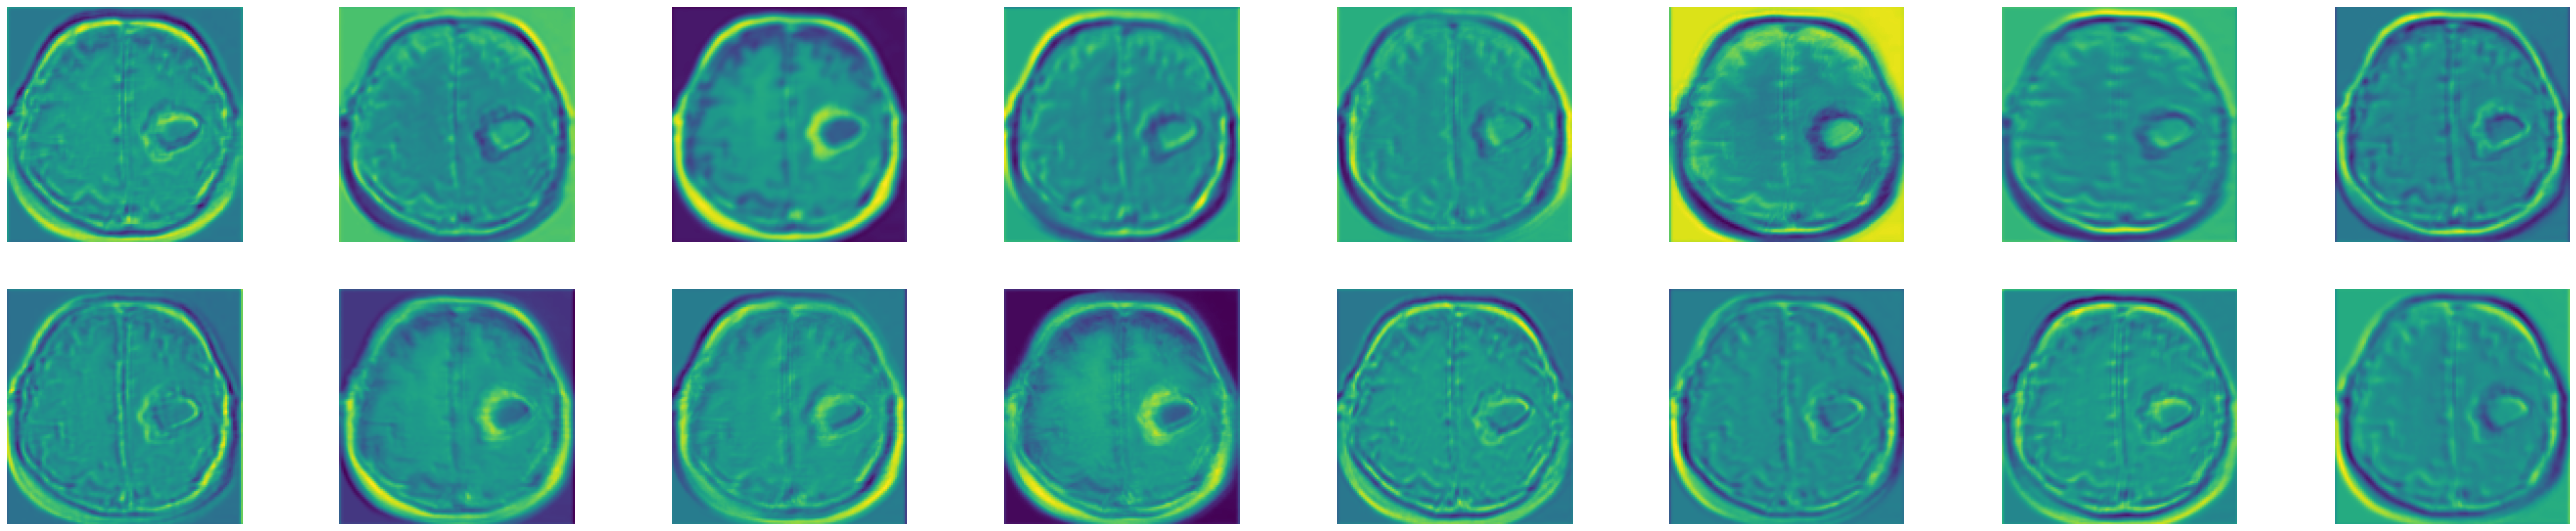

In [63]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()